In [1]:
!pip install -U keras==2.1.5

Requirement already up-to-date: keras==2.1.5 in c:\users\kouga\anaconda3\lib\site-packages (2.1.5)


In [2]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
import sys 
!{sys.executable} -m pip install tensorflow==1.15.0

  Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [1]:
import keras
print(keras.__version__)
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image,display_png
import numpy as np
from keras.applications import vgg19
from keras import backend as K

Using TensorFlow backend.


2.1.5


# 1. 画像の読み込み

In [2]:
target_img_path = './target/horato.jpg'
style_img_path = './style/iro.jpg'

width, height = load_img(target_img_path).size
img_height = 400
img_width = int(width * img_height / height)

# 2. 前処理

In [3]:
def preprocess_img(img_path):
    img = load_img(img_path, target_size = (img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    
    return img

def deprocess_img(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

# 3. VGG19ネットワーク読み込み

In [4]:
target_img = K.constant(preprocess_img(target_img_path))
style_img = K.constant(preprocess_img(style_img_path))

gene_img = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_img, style_img, gene_img], axis = 0)

model = vgg19.VGG19(input_tensor = input_tensor, weights = 'imagenet', include_top = False)

print('Model loaded.')











Model loaded.


# 4. 各種損失関数の定義

In [5]:
#　コンテンツの損失関数

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

#　スタイルの損失関数

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

#　全変動損失関数

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# 5. 全損失の定義

In [6]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.05

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(gene_img)

# 6. 勾配降下法の定義

In [7]:
grads = K.gradients(loss, gene_img)[0]
fetch_loss_and_grads = K.function([gene_img], [loss, grads])

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        
        return grad_values

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# 7. スタイル変換

In [8]:
from scipy.optimize import fmin_l_bfgs_b
import imageio
import time

result_prefix = 'style_transfer_result'
iterations = 25

x = preprocess_img(target_img_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime = evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_img(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 3110131000.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 76s
Start of iteration 1
Current loss value: 2101292800.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 78s
Start of iteration 2
Current loss value: 1662003100.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 81s
Start of iteration 3
Current loss value: 1391284700.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 78s
Start of iteration 4
Current loss value: 1189646700.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 78s
Start of iteration 5
Current loss value: 1049165800.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 79s
Start of iteration 6
Current loss value: 925735740.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 80s
Start of iteration 7
Current

# 8. 変換前後の画像

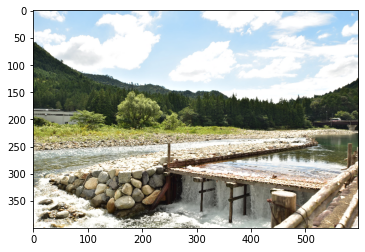

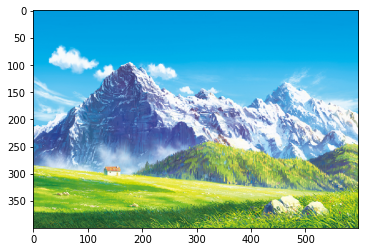

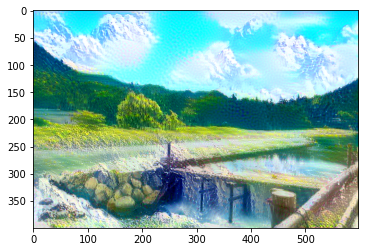

In [10]:
from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt

plt.imshow(load_img(target_img_path, target_size = (img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_img_path, target_size = (img_height, img_width)))
plt.figure()

plt.imshow(img)
plt.show()